In [ ]:
import keras
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score

Я не очень понял, в чём конкретно состоит первое задание. Поэтому сначала я сделал отдельный класс на один полносвязный слой. 


In [ ]:
def simple_SoftMAX(x):
    exps = np.exp(x)
    norm = np.sum(exps, axis = 1, keepdims = True)
    probs = exps / norm
    
    return probs

def Normalize(X):
    X_sum = X.sum(axis = 1, keepdims = True)
    print(X_sum.shape)
    X = X /X_sum
    
    return X

class very_simple_nn():
    def __init__(self, in_ftr, out_ftr):
        self.in_ftr = in_ftr
        self.out_ftr = out_ftr
        self.weights = np.random.rand(self.in_ftr, self.out_ftr) * 0.01
        
        self.constant = np.zeros(out_ftr).reshape((1, out_ftr))
        
    
    def train(self, X, Y, step = 0.1, epochs=10, shuffle=False, batch_size=1000):
        X_copy = np.copy(X)
        Y_copy = np.copy(Y)
        
        if shuffle:
            perm = np.random.permutation(X.shape[0])
            X_perm = X_copy[perm]
            Y_perm = Y_copy[perm]
        else:
            X_perm = X_copy
            Y_perm = Y_copy
            
        for epoch_num in range(epochs):
            bs = batch_size
            for bs_index in range((len(X_perm) + bs - 1) // bs):
                X_batch = X_perm[bs_index * bs: bs_index * bs + bs]
                Y_batch = Y_perm[bs_index * bs: bs_index * bs + bs]
                    
                res_nn = X_batch @ self.weights + self.constant  #forward
                res_sm = simple_SoftMAX(res_nn)                  #forward 
            
                grad_sm = np.copy(res_sm)                        #backward
                grad_sm[np.arange(res_nn.shape[0]), Y_batch] -= 1#backward
                grad_sm = grad_sm / res_nn.shape[0]              #backward
                
                d_weights = np.transpose(X_batch) @ grad_sm      
                d_constant = np.sum(grad_sm, axis = 0)
                
                self.weights = self.weights - step * d_weights   #update
                self.constant = self.constant - step * d_constant#update
                
    def predict(self, X_test):
        res_nn = X_test @ self.weights + self.constant
        res_sm = simple_SoftMAX(res_nn)
        return np.argmax(res_sm, axis = 1)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape((60000, 28 * 28))
X_test = X_test.reshape((10000, 28 * 28))

In [ ]:
X_train = Normalize(X_train)
X_test = Normalize(X_test)

(60000, 1)
(10000, 1)


In [ ]:
Test = very_simple_nn(28 * 28, 10)

Здесь я просто показал, что оно работает. Основная сеть в несколько слоёв написана ниже.

In [ ]:
Test.train(X_train, Y_train, step = 1, batch_size = 10000, epochs = 100, shuffle = True)

In [ ]:
acc = np.mean(Test.predict(X_test) == Y_test)
print(acc)

0.3239


Но на этой сети больше 0.9215 получить не удалось, поэтому я написал несколько слоёв:

In [ ]:
class slay_component():
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, x):
        raise NotImplementedError()
    
    def upgrade():
        pass


class simple_nn(slay_component):
    def __init__(self, in_ftr, out_ftr):
        self.in_ftr = in_ftr
        self.out_ftr = out_ftr
        self.weights = np.random.rand(self.in_ftr, self.out_ftr) * 0.01
        self.constants = np.zeros(self.out_ftr)
        self.x = None
        self.d_weights = None
        self.d_const = None
        
    def forward(self, x):
        self.x = np.copy(x)
        #print('nn')
        return self.x @ self.weights + self.constants
    
    def backward(self, local_gr):
        #print(self.x.shape)
        #print(local_gr.shape)
        #print(self.x)
        self.d_weights = np.transpose(self.x) @ local_gr
        self.d_const = np.sum(local_gr, axis = 0)
        return (local_gr @ np.transpose(self.weights))
    
    def update(self, step):
        #print(self.d_weights)
        self.weights = self.weights - step * self.d_weights
        self.constants = self.constants - step * self.d_const
        #print(self.weights.sum())
        
        
class ReLU(slay_component):
    def __init__(self):
        self.x = None
        
    def forward(self, x):
        #print('ReLU')
        self.x = np.copy(x)
        return np.maximum(0, self.x)
    
    def backward(self, local_gr):
        d_ReLU = self.x > 0
        return local_gr * d_ReLU
    
class SeLU(slay_component):
    def __init__(self):
        self.x = None
        self.lambda_0 = 1.0507
        self.alpha = 1.67327
        
    def forward(self, x):
        self.x = np.copy(x)
        return np.maximum(0, self.x) + np.minimum(self.lambda_0 * self.alpha * (np.exp(self.x) - 1), 0)
    
    def backward(self, local_gr):
        d_SeLU_pos = self.x > 0
        d_SeLU_neg = self.x <= 0
        d_SeLU = d_SeLU_pos * self.lambda_0 + d_SeLU_neg * self.lambda_0 * self.alpha * np.exp(self.x)
        return local_gr * d_SeLU
    
class SoftMAX(slay_component):
    def __init__(self):
        self.x = None
        self.probs = None
        
    def forward(self, x):
        #print('Softmax')
        self.x = np.copy(x)
        exps = np.exp(self.x)
        norm = np.sum(np.copy(exps), axis = 1, keepdims = True)
        self.probs = exps / norm
        return self.probs
    
    def backward(self, q):
        grad = np.copy(self.probs)
        grad[np.arange(self.x.shape[0]), q] -= 1 #возвращает градиент уже после применения кросс-энтропии
        return grad / self.x.shape[0]

Кроме стандартного ReLU, я написал SELU, так как читал, что при них картинки учатся лучше.

In [ ]:
class MNIST_Classifier:
    def __init__(self, slays, step = 0.01, epochs = 50, batch_size = 100,  shuffle = False):
        self.slay_components = slays + [SoftMAX()]
        self.step = step
        self.batch_size = batch_size
        self.epochs = epochs
        self.is_shuffle = shuffle
        
    def forward(self, X):
        res = X
        for comp in self.slay_components:
            #print(comp)
            #print(len(res.shape))
            #print(res.shape)
            res = comp.forward(res)
        return res
    
    def backward(self, grad):
        res = grad
        for inv, comp in enumerate(reversed(self.slay_components)):
            #print(grad)
            res = comp.backward(res)
    
    def update(self):
        for comp in self.slay_components:
            if isinstance(comp, simple_nn):
                #print('I am here')
                comp.update(self.step)
    
    def train(self, X, Y):
        if self.is_shuffle:
            perm = np.random.permutation(X.shape[0])
            X_perm = X[perm]
            Y_perm = Y[perm]
        else:
            X_perm = X
            Y_perm = Y
            
        for epoch_num in range(self.epochs):
            local_batch_size = self.batch_size
            for batch_index in range((len(X_perm) + local_batch_size - 1) // local_batch_size):
                batch_X = X_perm[batch_index * local_batch_size:batch_index * local_batch_size + local_batch_size]
                batch_Y = Y_perm[batch_index * local_batch_size:batch_index * local_batch_size + local_batch_size]
                
                self.forward(batch_X)
                self.backward(batch_Y)
                self.update()
                
    def predict(self, X):
        res = X
        for comp_index in range(len(self.slay_components)):
            res = self.slay_components[comp_index].forward(res)
            
        return np.argmax(res, axis = 1)

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape((60000, 28 * 28))
X_test = X_test.reshape((10000, 28 * 28))

In [ ]:
X_train = Normalize(X_train)
X_test = Normalize(X_test)

(60000, 1)
(10000, 1)


In [ ]:
Test = MNIST_Classifier([
    simple_nn(28*28, 256),
    SeLU(),
    simple_nn(256, 128),
    SeLU(),
    simple_nn(128, 10)
    ], epochs = 10, step = 0.1, shuffle=False)

Я сделал всего 300 эпох. Но этого должно хватить.


In [ ]:
Test.epochs = 10
for i in range(30):
    Test.train(X_train, Y_train)
    acc = np.mean(Test.predict(X_test) == Y_test)
    print("Epoch number ", i * 10 + 10, "  Accuracy: ", acc)

Epoch number  10   Accuracy:  0.1135
Epoch number  20   Accuracy:  0.2521
Epoch number  30   Accuracy:  0.4822
Epoch number  40   Accuracy:  0.7221
Epoch number  50   Accuracy:  0.8133
Epoch number  60   Accuracy:  0.842
Epoch number  70   Accuracy:  0.8748
Epoch number  80   Accuracy:  0.8975
Epoch number  90   Accuracy:  0.9036
Epoch number  100   Accuracy:  0.9119
Epoch number  110   Accuracy:  0.9159
Epoch number  120   Accuracy:  0.9206
Epoch number  130   Accuracy:  0.9242
Epoch number  140   Accuracy:  0.9282
Epoch number  150   Accuracy:  0.9306
Epoch number  160   Accuracy:  0.9332
Epoch number  170   Accuracy:  0.9368
Epoch number  180   Accuracy:  0.9394
Epoch number  190   Accuracy:  0.9425
Epoch number  200   Accuracy:  0.9458
Epoch number  210   Accuracy:  0.9476
Epoch number  220   Accuracy:  0.9497
Epoch number  230   Accuracy:  0.9508
Epoch number  240   Accuracy:  0.9511
Epoch number  250   Accuracy:  0.9518
Epoch number  260   Accuracy:  0.9515
Epoch number  270   Ac

In [ ]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()
X_test_img = np.copy(X_test)
X_train = X_train.reshape((60000, 28 * 28))
X_test = X_test.reshape((10000, 28 * 28))
X_test = Normalize(X_test)
X_test_img.shape


(10000, 1)


(10000, 28, 28)

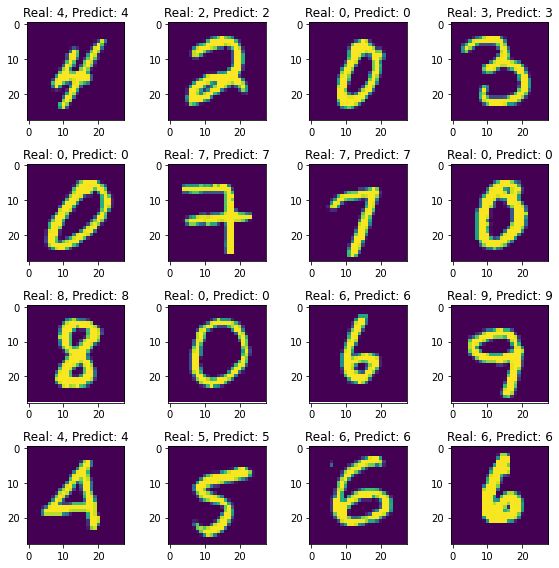

In [ ]:
rows = 4
cols = 4
axes=[]

nums = np.random.randint(0, X_test.shape[0], rows*cols)
imgs = X_test_img[nums]
imgs_to_predict = X_test[nums]
labels = Y_test[nums]
predicts = Test.predict(imgs_to_predict)
fig=plt.figure(figsize = [8, 8])

for i in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, i+1))
    subplot_title=("Real: {}, Predict: {}".format(labels[i], predicts[i]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(imgs[i])
fig.tight_layout()    
plt.show()

Нарисуем еще вот такую табличку, чтобы посмотреть, где мы ошибаемся.

In [ ]:
difference = [Test.predict(X_test) != Y_test]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which wil

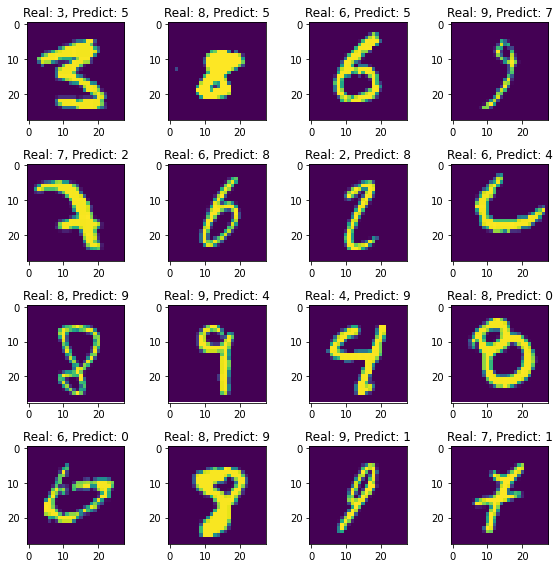

In [ ]:
X_test_difference = np.copy(X_test)
X_test_difference = X_test_difference[difference]
X_test_img_dif = np.copy(X_test_img)
X_test_img_dif = X_test_img_dif[difference]
Y_test_difference = np.copy(Y_test)
Y_test_difference = Y_test_difference[difference]

nums = np.random.randint(0, X_test_difference.shape[0], rows*cols)
imgs = X_test_img_dif[nums]
imgs_to_predict = X_test_difference[nums]
labels = Y_test_difference[nums]
predicts = Test.predict(imgs_to_predict)
fig=plt.figure(figsize = [8, 8])

for i in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, i+1))
    subplot_title=("Real: {}, Predict: {}".format(labels[i], predicts[i]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(imgs[i])
fig.tight_layout()    
plt.show()